In [1]:
import os
import pandas as pd
import seaborn as sns
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df



def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats\.txt"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 0
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: x[0])

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}


def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)

In [2]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,21393754.0,21665456.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,43321281.0,55780535.0,512,8,2,5,os,112,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/ws_bin_baseline_128_hw_112_f_4_nf_16_s_2_ArmO3CPU__stats.txt,0.025333,19762967.0,20034544.0,128,1,2,4,ws,112,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/ws_bin_baseline_128_hw_112_f_3_nf_8_s_2_ArmO3CPU__stats.txt,0.007277,6726844.0,6998421.0,128,1,2,3,ws,112,8
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/is_bin_baseline_256_hw_56_f_4_nf_8_s_1_ArmO3CPU__stats.txt,0.003758,11708226.0,12708504.0,256,1,1,4,is,56,8
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/os_bin_baseline_128_hw_112_f_4_nf_16_s_2_ArmO3CPU__stats.txt,0.004801,21525098.0,21796771.0,128,1,2,4,os,112,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/os_bin_baseline_128_hw_56_f_3_nf_16_s_1_ArmO3CPU__stats.txt,0.003189,13628103.0,13899772.0,128,1,1,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/ws_8bt_baseline_256_hw_56_f_5_nf_8_s_2_ArmO3CPU__stats.txt,0.001980,5521048.0,6088508.0,256,8,2,5,ws,56,8
/home/zhouzikai/nn_ext_dataflows/baselines/log_ARMO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,4460928.0,4732103.0,128,8,2,3,os,56,16


In [3]:
df_ex = df_ex[COL_FILTER]
df_ex

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_1_fs_5_os_ws_13_is_0_hw_112_nf_2_ArmO3CPU__stats.txt,0.002110,9320922.0,11229044.0,256,0,1,5,os,112,2
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_8bt_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025483,10829834.0,13067137.0,512,8,2,4,ws,112,8
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_1_fs_4_is_ws_7_os_6_hw_112_nf_16_ArmO3CPU__stats.txt,0.010693,19591710.0,20408402.0,256,0,1,4,is,112,16
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl128_8bt_stride_1_fs_4_ws_os_0_is_29_hw_56_nf_2_ArmO3CPU__stats.txt,0.000115,2083798.0,2352962.0,128,8,1,4,ws,56,2
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_8bt_stride_1_fs_5_os_ws_5_is_0_hw_56_nf_32_ArmO3CPU__stats.txt,0.013565,43988994.0,71331706.0,512,8,1,5,os,56,32
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_2_fs_5_os_ws_13_is_0_hw_56_nf_16_ArmO3CPU__stats.txt,0.000811,6989825.0,8526483.0,256,0,2,5,os,56,16
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl512_bin_stride_1_fs_3_os_ws_4_is_0_hw_112_nf_4_ArmO3CPU__stats.txt,0.004915,13011871.0,17333662.0,512,0,1,3,os,112,4
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_8bt_stride_1_fs_5_os_ws_13_is_0_hw_56_nf_4_ArmO3CPU__stats.txt,0.000569,4301631.0,5391771.0,256,8,1,5,os,56,4
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3/vl256_bin_stride_2_fs_3_ws_os_13_is_0_hw_56_nf_8_ArmO3CPU__stats.txt,0.000177,2325569.0,2661659.0,256,0,2,3,ws,56,8


In [4]:
df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           0        1      3           56       1           is                      0.000088  \
                                                               os                      0.000070   
                                                               ws                      0.000054   
                                                   2           is                      0.000106   
                                                               os                      0.000090   
...                                                                                         ...   
512           8        2      5           112      16          os                      0.012243   
                                                               ws                      0.079205   
                                                   32          is                      0.036128   
                                                               os                      0.024727   
                                                               ws                      0.158371   

                                                                                        simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                
128           0        1      3           56       1           is                      1775356.0  \
                                                               os                      1832004.0   
                                                               ws                      1772460.0   
                                                   2           is                      1884023.0   
                                                               os                      2006379.0   
...                                                                                          ...   
512           8        2      5           112      16          os                     23932938.0   
                                                               ws                     30322425.0   
                                                   32          is                    133187985.0   
                                                               os                     46208430.0   
                                                               ws                     58990644.0   

                                                                                          simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           0        1      3           56       1           is                      2046179.0  
                                                               os                      2101109.0  
                                                               ws                      2041586.0  
                                                   2           is                      2154854.0  
                                                               os                      2275492.0  
...                                                                                          ...  
512           8        2      5           112      16          os                     41681729.0  
                                                               ws                     36741913.0  
                                                   32          is                    173478181.0  
                                                               os                     81436901.0  
                                                               ws                     71564876.0  

[972 rows x 3 columns]

In [5]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [6]:
NUM_FILTER_LOWER = 1
NUM_FILTER_UPPER = 32
VEC_LEN_LIST = [128,256]

In [7]:
df_merged = df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST)) & (df_merged["stride"]==1)]

<Axes: xlabel='simSeconds'>

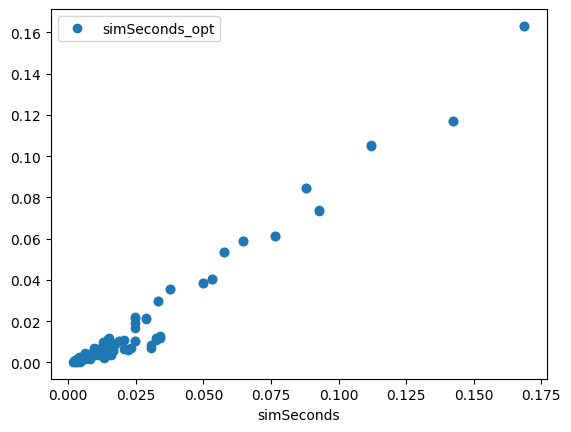

In [8]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

In [9]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  8.,  4.,  0.,  4., 10.,
         3.,  2.,  1.,  1.,  2.,  0.,  0.,  2.,  2.,  4.,  1.,  5.,  3.,
         2.,  2.,  0.,  0.,  3.,  2.,  0.,  3.,  2.,  3.,  2.,  0.,  0.,
         0.,  4.,  0.,  2.,  3.,  1.,  3.,  1.,  2.,  1.,  2.,  2.,  2.,
         0.,  1.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,  1.,  2.,  1.,
         0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.

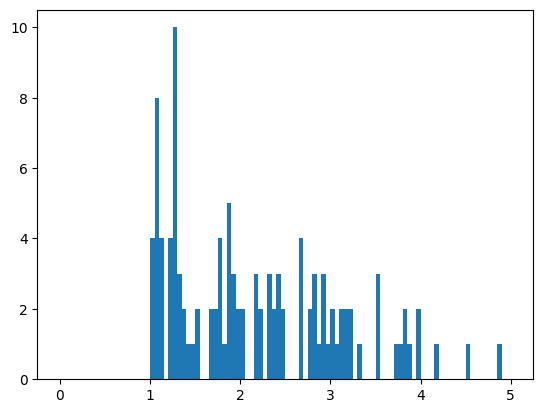

In [10]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=100)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 2., 2., 0.,
        0., 0., 0., 0., 1., 1., 0., 2., 1., 2., 1., 2., 2., 2., 0., 1., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
        3.85, 3.9 , 3.95, 4.  , 

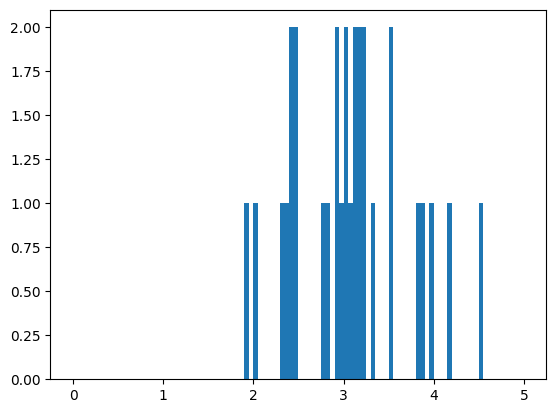

In [11]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=100)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 2., 0., 0., 1.,
        2., 3., 1., 5., 2., 2., 1., 0., 0., 3., 2., 0., 2., 0., 0., 0., 0.,
        0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
        3.85, 3.9 , 3.95, 4.  , 

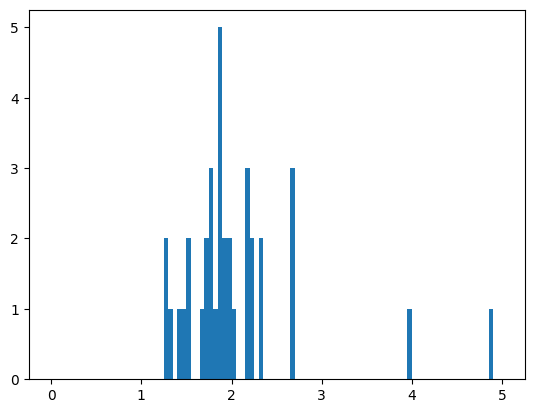

In [12]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=100)

In [13]:
df_merged['improvement'].mean()

2.561468964437937

In [14]:
df_merged['improvement'].median()

2.0957950640620555

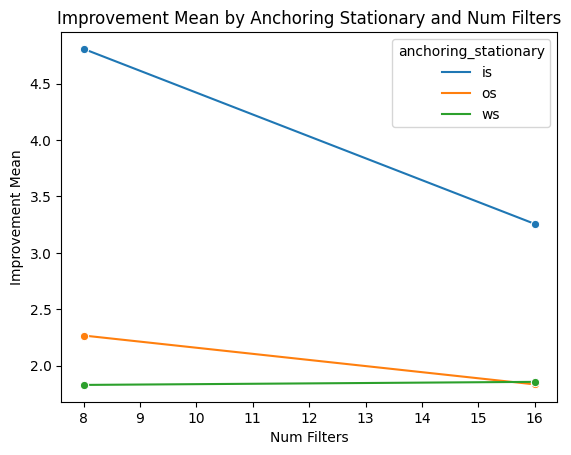

In [15]:

grouped_df = df_merged.groupby(["anchoring_stationary","num_filters"])["improvement"].mean().reset_index()
sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Mean')
plt.title('Improvement Mean by Anchoring Stationary and Num Filters')
plt.show()

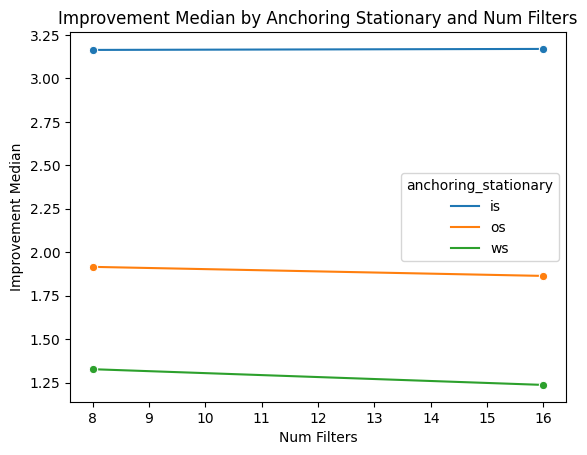

In [16]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters'
)
plt.show()

In [17]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==4)]["improvement"].mean()

nan

In [18]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==4)]["improvement"].median()

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan

In [19]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==8)]["improvement"].mean()

3.5371293664998054

In [20]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==8)]["improvement"].median()

2.657397926477264

In [21]:
df_merged[(df_merged["anchoring_stationary"]=="is")&(df_merged["num_filters"]==8)]["improvement"].median()

3.164122518541376

In [22]:
df_merged[(df_merged["anchoring_stationary"]=="os")&(df_merged["num_filters"]==8)]["improvement"].median()

1.9157458376264436

In [23]:
df_merged[(df_merged["anchoring_stationary"]=="is")&(df_merged["num_filters"]==16)]["improvement"].median()

3.169870500519705

In [24]:
df_merged[(df_merged["anchoring_stationary"]=="os")&(df_merged["num_filters"]==16)]["improvement"].median()

1.8636455132892458

In [25]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==16)]["improvement"].mean()

2.5450536779812385

In [26]:
df_merged[(df_merged["anchoring_stationary"]!="ws")&(df_merged["num_filters"]==16)]["improvement"].median()

2.2216830645630785

In [27]:
df_merged[df_merged["anchoring_stationary"]=="is"]["simSeconds_opt"].mean()

0.003772171296296297

In [28]:
df_merged[df_merged["anchoring_stationary"]=="os"]["simSeconds_opt"].mean()

0.0043173981481481475

In [29]:
df_merged[df_merged["anchoring_stationary"]=="is"]["simSeconds_opt"].median()

0.001354

In [30]:
df_merged[df_merged["anchoring_stationary"]=="os"]["simSeconds_opt"].median()

0.0017929999999999999

In [31]:
df_ex_is = df_ex[df_ex["anchoring_stationary"]=="is"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])
df_ex_os = df_ex[df_ex["anchoring_stationary"]=="os"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])
df_ex_ws = df_ex[df_ex["anchoring_stationary"]=="ws"].drop(columns=["simInsts_opt","simOps_opt","anchoring_stationary"])

In [32]:
df_ex_is = df_ex_is.rename(columns={"simSeconds_opt":"simSecondsIS"})
df_ex_ws = df_ex_ws.rename(columns={"simSeconds_opt":"simSecondsWS"})
df_ex_os = df_ex_os.rename(columns={"simSeconds_opt":"simSecondsOS"})

In [33]:
df_isaws = pd.merge(df_ex_is,df_ex_ws,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_triple = pd.merge(df_isaws,df_ex_os,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [34]:
df_triple = df_triple[(df_triple["num_filters"]>=32) & (df_triple["num_filters"]<=64)]

<Axes: >

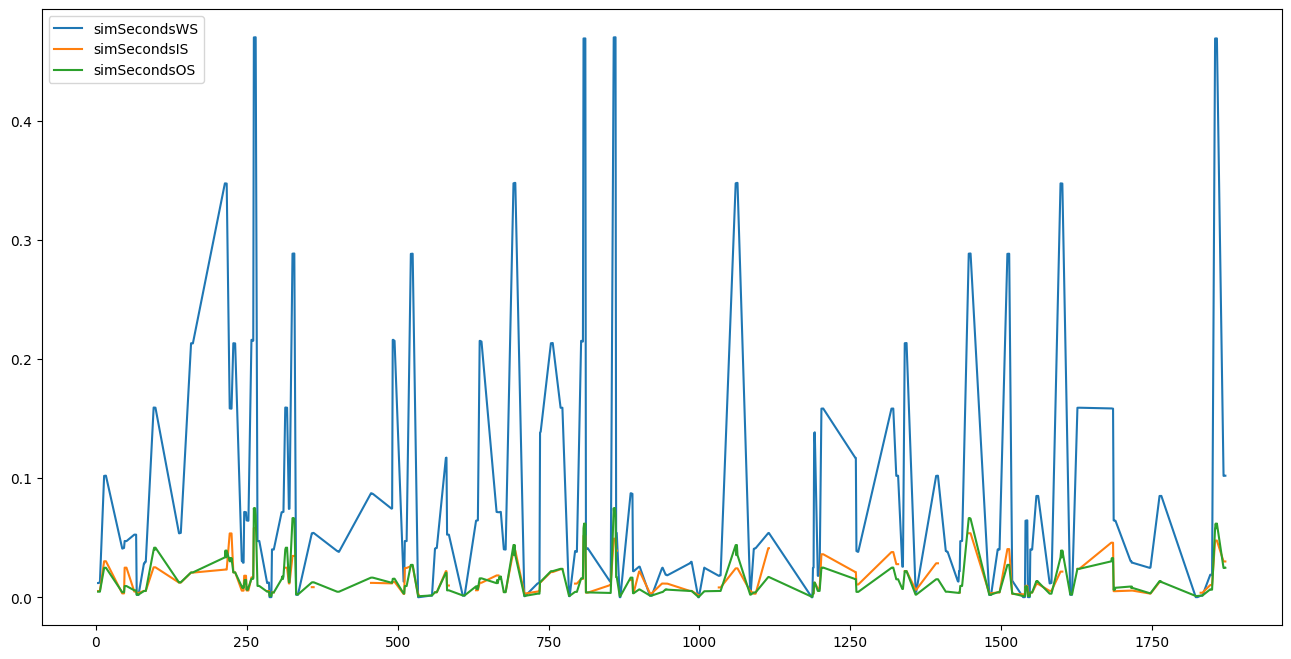

In [35]:
df_triple.plot(y=["simSecondsWS","simSecondsIS","simSecondsOS"],figsize=(16,8))

In [36]:
df_triple["os_vs_is"] = df_triple["simSecondsIS"] - df_triple["simSecondsOS"]

<Axes: >

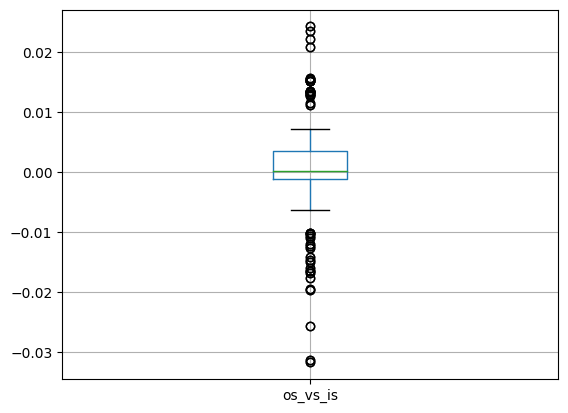

In [37]:
df_triple.boxplot(column="os_vs_is")

In [38]:
len(df_triple[df_triple.os_vs_is > 0])/len(df_triple)

0.4362745098039216

In [39]:
df_triple["os_vs_ws"] = df_triple["simSecondsWS"] / df_triple["simSecondsOS"]

<Axes: >

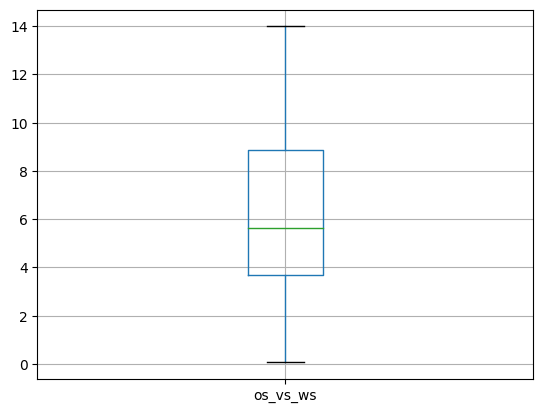

In [40]:
df_triple.boxplot(column="os_vs_ws")

In [41]:
df_triple["is_vs_ws"] = df_triple["simSecondsWS"] / df_triple["simSecondsIS"]

<Axes: >

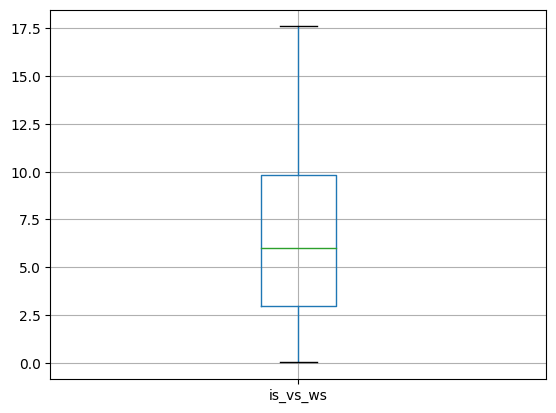

In [42]:
df_triple.boxplot(column="is_vs_ws")